# Subcellular Location Prediction via Scikit-Learn

This notebook attempts to prediction subcellular location (q10 classification) using relatively simple sklearn models. In the previous notebooks, we used the TAPE pretrained transformer model to generate embeddings of all the sequences in the DeepLoc dataset, which we use as features for these simpler models

In [1]:
from itertools import cycle
import json

from Bio import SeqIO
from Bio.Alphabet import IUPAC
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interp
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import xgboost as xgb
import torch

### Data Loading

In [2]:
def gen_df(embeddings):
    """
    Iterate over all of the sequence IDs in the given subset of the dataset (embeddings),
    as a nested numpy array. Produce a numpy array of the average embeddings for each
    sequence, as will a list of the labels by looking up the sequence IDs in seq_id_to_label
    
    Args:
        embeddings (numpy.lib.npyio.NpzFile): Nested numpy array containing embeddings for each sequence ID
        seq_id_to_label (dict[str,str]): Map from sequence ID to classification label
    
    Returns:
        output (pd.DataFrame): Average embeddings for each sequence
        labels (list[str])
    """
    keys = embeddings.files
    output, labels = [], []
    for key in keys:
        d = embeddings[key].item()["avg"]
        labels.append(seq_id_to_label[key])
        output.append(d)
    return pd.DataFrame(output), labels

In [3]:
seq_id_to_label = {}
seq_list = []

# generate lookup dictionary for labels from sequences in original fasta file 
for record in SeqIO.parse("../data/deeploc_data_6000.fasta", "fasta"):
    description = record.description
    seq = record.seq
    seq_list.append(len(str(seq)))
    desc_split = description.split(" ")
    ID = desc_split[0]
    label = desc_split[1]
    label = label[:len(label)-2]
    seq_id_to_label[ID] = label

In [4]:
# load embedded sequences from npz files
train_arrays = np.load('../data/output_deeploc_train_6000.npz', allow_pickle=True)
valid_arrays = np.load('../data/output_deeploc_valid_6000.npz', allow_pickle=True)
test_arrays = np.load('../data/output_deeploc_test_6000.npz', allow_pickle=True)

### Create Training DataFrames and  Label Data Sets

In [5]:
id_dict = {
    'Cell.membrane': 0, 
    'Cytoplasm': 1, 
    'Endoplasmic.reticulum': 2, 
    'Golgi.apparatus': 3, 
    'Lysosome/Vacuole': 4,
    'Mitochondrion': 5, 
    'Nucleus': 6,
    'Peroxisome': 7, 
    'Plastid': 8,
    'Extracellular': 9
}

In [6]:
train_df, train_labels = gen_df(train_arrays)
valid_df, valid_labels = gen_df(valid_arrays)
test_df, test_labels = gen_df(test_arrays)

In [7]:
print(train_df.shape)
print(valid_df.shape)
print(test_df.shape)

(9974, 768)
(1109, 768)
(2773, 768)


In [8]:
train_valid_df = train_df.append(valid_df, ignore_index=True)
train_valid_labels = train_labels + valid_labels
train_y = [id_dict[label] for label in train_valid_labels]
test_y = [id_dict[label] for label in test_labels]

### XGBoost Classifier

In [10]:
d_train = xgb.DMatrix(train_valid_df, label=train_y)
d_test = xgb.DMatrix(test_df,label=test_y)

In [11]:
param = {
    'eta': 0.25, 
    'max_depth': 10,  
    'objective': 'multi:softprob',  
    'num_class': 10,
    'eval_metric': 'auc'} 

steps = 50  # The number of training iterations

In [12]:
model = xgb.train(param, d_train, steps)

In [13]:
preds = model.predict(d_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

In [14]:
print("Precision = {}".format(precision_score(test_y, best_preds, average='macro')))
print("Recall = {}".format(recall_score(test_y, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(test_y, best_preds)))

Precision = 0.5138482134046775
Recall = 0.44418708796177253
Accuracy = 0.6307248467363866


# Logistic Regression - ROC Curves - One vs. Rest Classifier

In [15]:
# Combine Valid And Train data sets 
train_valid_df = train_df.append(valid_df, ignore_index=True)
train_valid_labels = train_labels + valid_labels

In [16]:
# Append labels to data frame
train_y = [id_dict[label] for label in train_valid_labels]
test_y = [id_dict[label] for label in test_labels]

In [17]:
# Binarize the output for One Vs. Rest Classifiers
y_train = label_binarize(train_y, classes=[0,1,2,3,4,5,6,7,8,9])
y_test = label_binarize(test_y, classes=[0,1,2,3,4,5,6,7,8,9])
n_classes = y_test.shape[1]

In [18]:
# Run the On Vs. Rest Classifier
clf = OneVsRestClassifier(LogisticRegression(solver='newton-cg', random_state=42, multi_class='multinomial'))
y_score = clf.fit(train_valid_df, y_train).decision_function(test_df)

In [20]:
# TODO Add classification accuracy w/o one vs rest for Logistic and SVC

In [21]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

/Users/rdedhia/Documents/ucsd/capstone/tape/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  


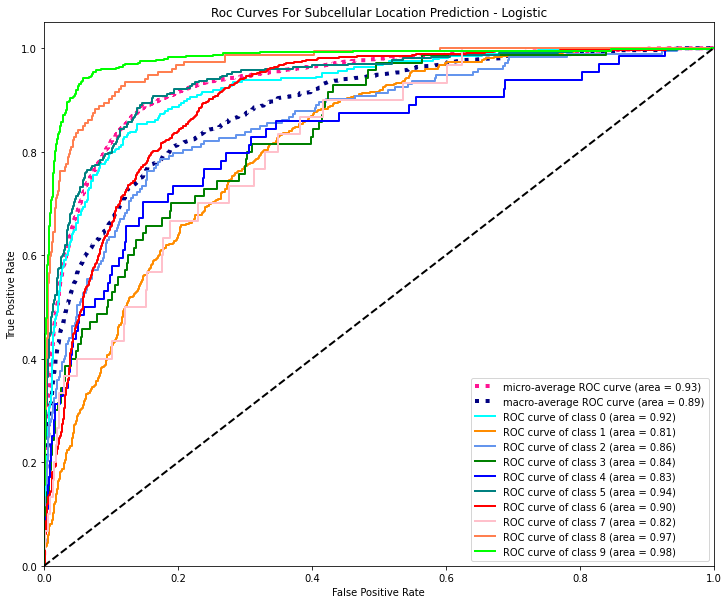

In [24]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
lw=2

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(12,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue','green','blue','teal','red','pink','coral','lime'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc Curves For Subcellular Location Prediction - Logistic')
plt.legend(loc="lower right")
plt.show()

# One vs. Rest Classifier using SVC

In [ ]:
# Run SVC Classifer Using Best Parameters for Grid Search CV
clf = OneVsRestClassifier(SVC(kernel='poly',C=500, max_iter=100000))
y_score = clf.fit(train_valid_df, y_train).decision_function(test_df)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(12,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue','green','blue','teal','red','pink','coral','lime'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc Curves For Subcellular Location Prediction - SVC')
plt.legend(loc="lower right")
plt.show()